<h3><b>Homework 4 - Imaging</b></h3>

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import data
from skimage.io import imread
from skimage.color import rgb2gray
from ProblemiInversi import operators, solvers, utilities

<b>Esercizio 1: compressione di immagini con SVD</b>

Data una immagine associata ad una matrice $A$ di dimensione $m \times n$ la formula
$$
A_p = \sum_{i=1}^p u_i v_i^T \sigma_i 
$$
è la formula di <i>Single Value Decomposition (SVD)</i> applicata alla compressione di immagini sapendo che qualsiasi immagine può essere vista come la scomposizione di una somma di immagini sovrapposte. La sommatoria si legge come "somma dei primi $p$ layer più importanti dell'immagine originale.

In [16]:
def image_SVD(A, p):
    U, sigma, Vt = np.linalg.svd(A, full_matrices=False)
    Ap = np.zeros_like(A, dtype=float)

    for i in range(p):
        Ap += sigma[i] * np.outer(U[:, i], Vt[i, :])
    return Ap

Prendiamo ora una immagine, portiamola in scala di grigi se necessario e procediamo

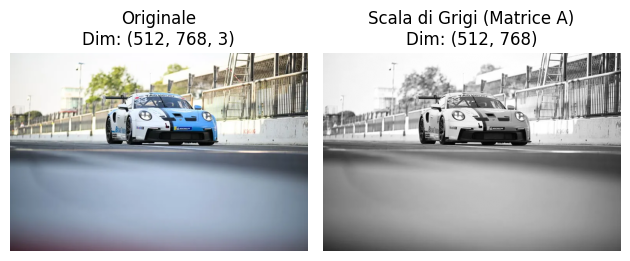

In [17]:
# Lettura dell'immagine
porsche = "porsche_gt3cup.jpg"
image_raw = imread(porsche)

# Conversione in scala di grigi
if len(image_raw.shape) == 3:
    A = rgb2gray(image_raw)
else:
    A = np.array(image_raw, dtype=float)

# Immagine Originale (a colori se presente)
plt.subplot(1, 2, 1)
plt.imshow(image_raw)
plt.title(f"Originale\nDim: {image_raw.shape}")
plt.axis("off")

# Immagine in Scala di Grigi 
plt.subplot(1, 2, 2)
plt.imshow(A, cmap='gray') 
plt.title(f"Scala di Grigi (Matrice A)\nDim: {A.shape}")
plt.axis("off")

plt.tight_layout()
plt.show()


Procediamo a calcolare l'errore relativo secondo la formula
$$
\frac{||A - A_p||_2}{||A||_2} 
$$
Andiamo quindi a collaudare l'algoritmo con una lista di valori per $p$ per avere vari livelli di compressione.

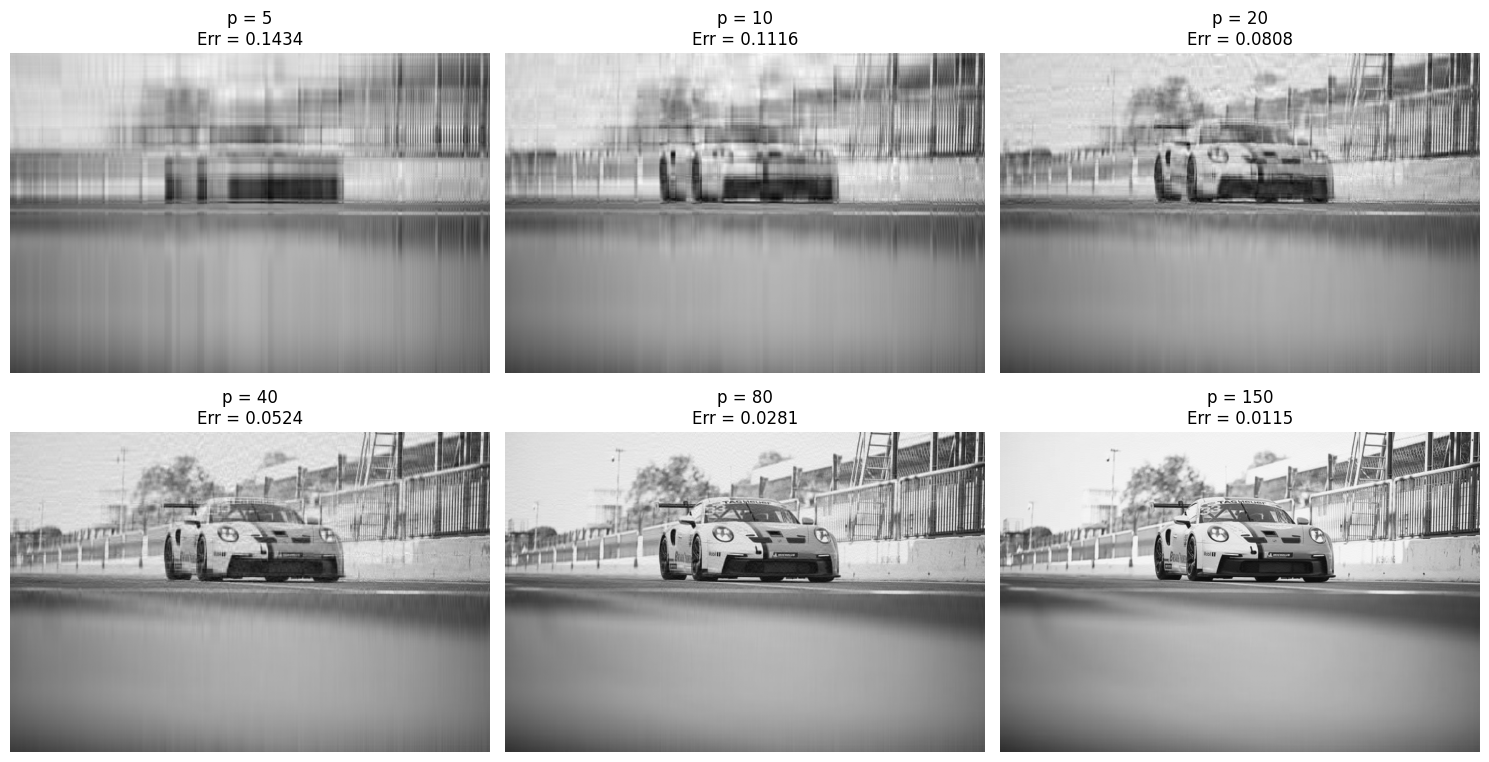

In [18]:
# Calcolo errore relativo
pp = [5, 10, 20, 40, 80, 150]
m, n = A.shape
max_rank = min(m, n)
errori_relativi = []
fattori_compressione = []

plt.figure(figsize=(15, 8))
for i, p in enumerate(pp):
    Ap = image_SVD(A, p)
    err = np.linalg.norm(A - Ap) / np.linalg.norm(A)
    errori_relativi.append(err)

    cp = (1/p) * min(m, n) - 1
    fattori_compressione.append(cp)
    if i < 6:
        plt.subplot(2, 3, i+1)
        plt.imshow(Ap, cmap='grey')
        plt.title(f"p = {p}\nErr = {err:.4f}")
        plt.axis("off")
plt.tight_layout()
plt.show()

Andiamo ora a visualizzare graficamente i risultati del procedimento

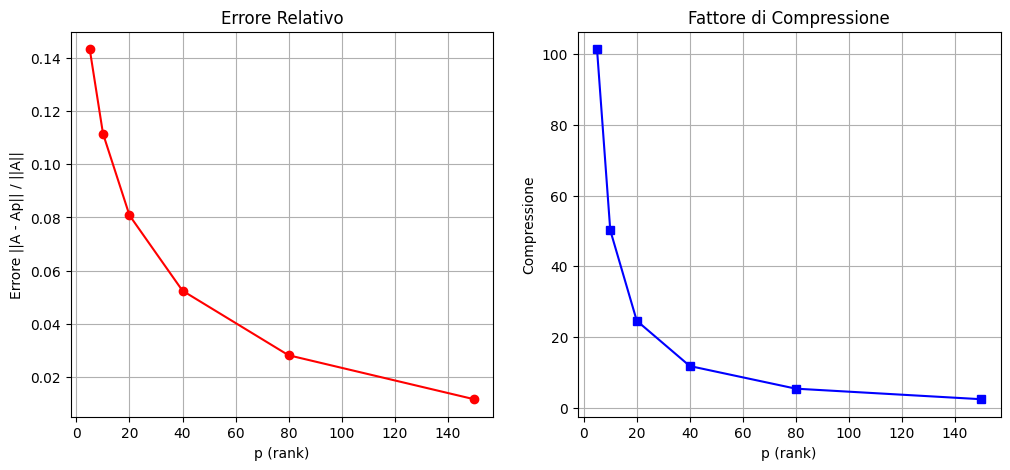

,Valore di p,Errore relativo,Fattore di compressione
0,5,0.143363,101.400000
1,10,0.111574,50.200000
2,20,0.080773,24.600000
3,40,0.052390,11.800000
4,80,0.028085,5.400000
5,150,0.011514,2.413333


In [19]:
plt.figure(figsize=(12, 5))

# Grafico 1: Errore Relativo vs p
plt.subplot(1, 2, 1)
plt.plot(pp, errori_relativi, 'o-', color='red')
plt.title("Errore Relativo")
plt.xlabel("p (rank)")
plt.ylabel("Errore ||A - Ap|| / ||A||")
plt.grid()

# Grafico 2: Fattore di Compressione vs p
plt.subplot(1, 2, 2)
plt.plot(pp, fattori_compressione, 's-', color='blue')
plt.title("Fattore di Compressione")
plt.xlabel("p (rank)")
plt.ylabel("Compressione")
plt.grid()
plt.show()

tabella_riassuntiva = pd.DataFrame({
    "Valore di p": pp,
    "Errore relativo": errori_relativi,
    "Fattore di compressione": fattori_compressione
})
display(tabella_riassuntiva)

<b>Considerazioni:</b> possiamo notare, anche solo guardando le immagini, come il fattore di compressione diminuisca drasticamente (sino a 0) all'aumentare del valore di $p$. Difatti per valori bassi di $p$ otteniamo un'immagine molto brutta ma molto leggera, viceversa per valori alti di $p$ otteniamo l'immagine originale per un'occupazione di memoria maggiore.

<b>Esercizio 2: image deblur</b>

E' quindi necessario applicare una regolarizzazione. Iniziamo considerando la <b>funzione di regolarizzazione di Tikhonov</b>:

$$min_x f(x)= min_x||Ax-y^{\delta}||_2^2 + \lambda ||x||_2^2$$

dove $\lambda$ è il parametro di regolarizzazione.

Applicando le condizioni del primo ordine $\nabla(f)=0$  alla precdente funzione (convessa), si ottiene:

$$(A^TA+ \lambda I)x=A^Ty^{\delta}$$

Questo sistema lineare ha matrice ancora simmetrica e definita positivia quindi posso risolverlo applicando il metodo CGLS.

In [20]:
# Creazione del problema test

x = rgb2gray(image_raw)
nx, ny = x.shape
x = x / x.max() # Normalizzo nel range [0, 1]

# Definizione di kernel di blur e operatore associato
kernel = utilities.gaussian2d_kernel(k=11, sigma=3.5)
A = operators.ConvolutionOperator(kernel)

# Sfocatura dell'immagine e aggiunta di rumore
y = A(x)
y_delta = y + utilities.gaussian_noise(y, noise_level=0.05)

Calcolo della soluzione naive

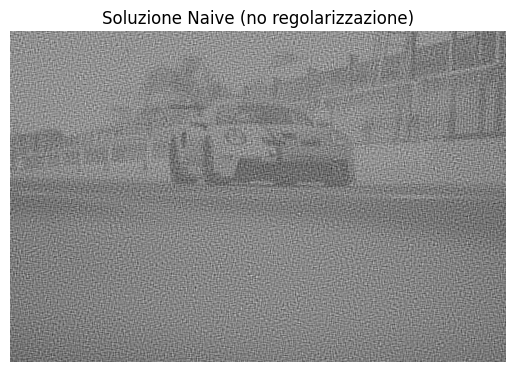

In [21]:
solver_naive = solvers.CGLS(A) 
# Usa un kmax basso per vedere la semi-convergenza o alto per vedere l'esplosione del rumore
x_naive = solver_naive.solve(y_delta, np.zeros_like(x), kmax=50, tolf=1e-5, tolx=1e-5)

plt.imshow(x_naive, cmap='gray')
plt.title("Soluzione Naive (no regolarizzazione)")
plt.axis("off")
plt.show()

Cominciamo esguendo un ciclo per calcolare la soluzione con Tikhonov per vari valori di $\lambda$ andando a verificare che l'errore diminuisca e osservare come si comporta il residuo.

Inizio calcolo per 5 valori di lambda...



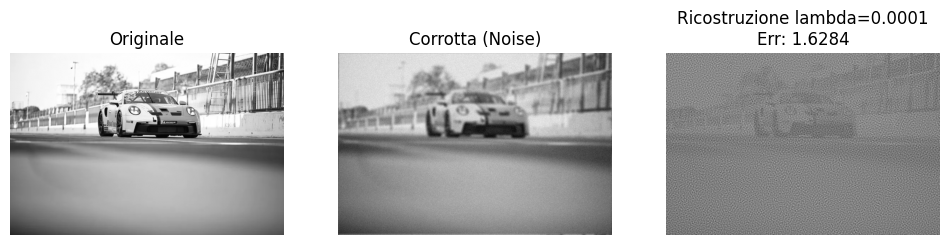

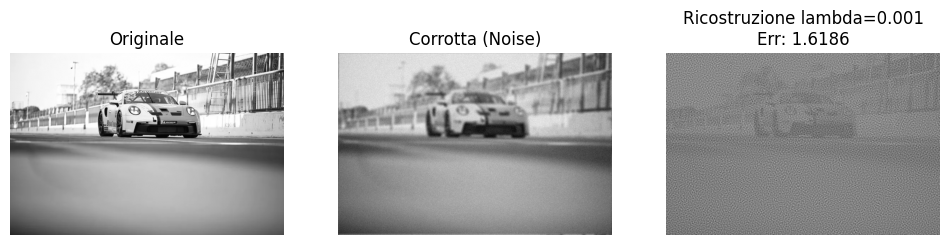

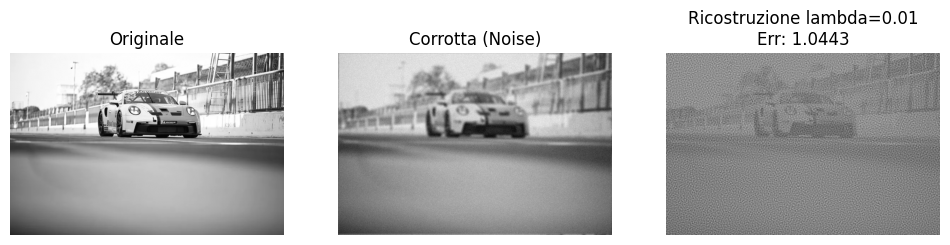

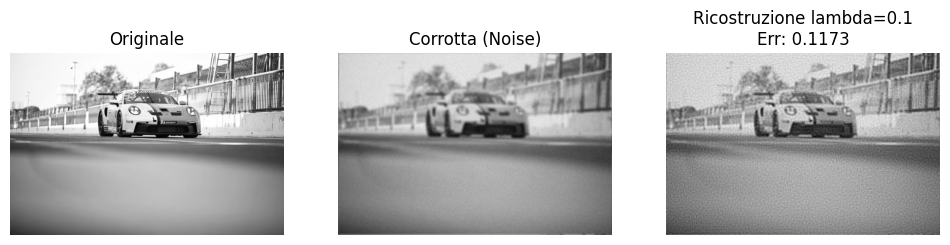

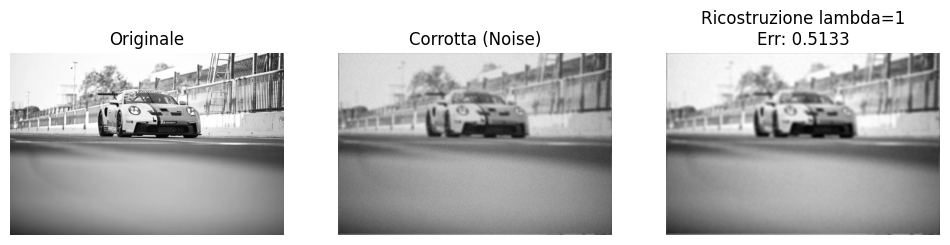

In [22]:
# Definisci i lambda che vuoi visualizzare
# (Puoi metterne quanti ne vuoi, ma se sono troppi avrai troppe figure)
lambdas = [0.0001, 0.001, 0.01, 0.1, 1] 

# Inizializzazione liste per salvare i dati (serviranno nelle celle successive)
x_tik_list = []
errori_relativi = []
psnr_vector = []
ssim_vector = []
residui = [] # FONDAMENTALE per il principio di discrepanza

L = operators.Identity()

# Padding corretto basato sulle dimensioni di y_delta
pad_rows = x.shape[0] # Assumendo immagine quadrata o rettangolare
ybar_delta = np.pad(y_delta, ((0, pad_rows), (0, 0))) # Padding [y; 0]
x0 = np.zeros_like(x)

print(f"Inizio calcolo per {len(lambdas)} valori di lambda...\n")

for lmbda in lambdas:
    # 1. Setup Operatore
    M = operators.TikhonovOperator(A, L, lmbda)
    cgls_tik_solver = solvers.CGLS(M)

    # 2. Soluzione
    # Aumentiamo un po' le iterazioni o abbassiamo la tolleranza per essere precisi
    x_tikhonov = cgls_tik_solver.solve(ybar_delta, x0, kmax=100, tolf=1e-6, tolx=1e-6)
    
    # 3. Calcolo Metriche e Salvataggio
    x_tik_list.append(x_tikhonov)
    
    # Errore relativo (vs Ground Truth)
    err_rel = utilities.rel_err(x_tikhonov, x)
    errori_relativi.append(err_rel)
    
    # Metriche qualità
    psnr_val = utilities.psnr(x_tikhonov, x)
    psnr_vector.append(psnr_val)
    
    ssim_val = utilities.ssim(x_tikhonov, x)
    ssim_vector.append(ssim_val)
    
    # Residuo (vs Dati Rumorosi) -> ||Ax - y_delta||
    # Questo serve per il Principio di Discrepanza
    # Se A è un operatore, usiamo A(x) o A.matvec(x)
    if hasattr(A, 'matvec'):
        Ax = A.matvec(x_tikhonov.flatten()).reshape(x.shape)
    else:
        Ax = A(x_tikhonov)
    
    res_val = np.linalg.norm(Ax - y_delta)
    residui.append(res_val)

    # 4. Visualizzazione (SOLO QUI nel ciclo)
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(x, cmap="gray")
    plt.title("Originale")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(y_delta, cmap="gray")
    plt.title(f"Corrotta (Noise)")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(x_tikhonov, cmap="gray")
    plt.title(f"Ricostruzione lambda={lmbda}\nErr: {err_rel:.4f}")
    plt.axis("off")
    
    plt.show()

Possiamo notare come, all'aumentare di $\lambda$ l'errore relativo diminuisca tranne per $\lambda = 1$ che trova un errore maggiore rispetto a $\lambda=0.1$ dato dal fatto che abbiamo esagerato con la pulizia e abbiamo buttato troppe informazioni (fra cui anche quelle utili).<br><br>
Procediamo ora a calcolare la soluzione con la regolarizzazione di Tikhonov, volendo anche calcolare il valore ottimale del parametro di regolarizzazione. Per scegliere il valore ottimale di $\lambda$ utilizziamo la formula del <b>ground truth</b>:
$$\lambda_{opt}=min_{\lambda}||x_{\lambda}-x_{GT}||_2^2$$
dove $x_\lambda$ è la soluzione calcolata in corrispondenza di un certo $\lambda$ e $x_{GT}$. 

Calcolo Tikhonov per 10 valori di lambda in corso...
Calcolo terminato.
Miglior Lambda (Min Errore): 2.78e-01 con Errore Relativo: 0.1326


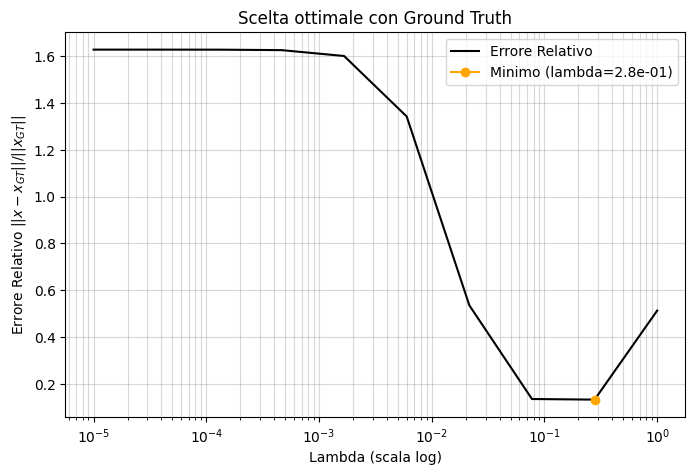

In [26]:
lambdas = np.logspace(-5, 0, 10)  # 50 valori tra 10^-5 e 1
x_tik_list = []      # Salviamo le immagini
errori_relativi = [] # Salviamo gli errori (per questo blocco)
residui = []         # Salviamo i residui (serviranno nel PROSSIMO blocco)
psnr_vector = []

L = operators.Identity()
x0 = np.zeros_like(x)

# Prepariamo il termine noto con padding (uguale per tutti)
pad_rows = x.shape[0]
ybar_delta = np.pad(y_delta, ((0, pad_rows), (0, 0)))

print(f"Calcolo Tikhonov per {len(lambdas)} valori di lambda in corso...")

# --- 2. CICLO DI CALCOLO ---
for lmbda in lambdas:
    # Definizione problema e solver
    M = operators.TikhonovOperator(A, L, lmbda)
    cgls_tik_solver = solvers.CGLS(M)
    
    # Risoluzione
    x_tik = cgls_tik_solver.solve(ybar_delta, x0, kmax=100, tolf=1e-6, tolx=1e-6)
    x_tik_list.append(x_tik)
    
    # Calcolo Errore Relativo (Ground Truth)
    err_rel = utilities.rel_err(x_tik, x)
    errori_relativi.append(err_rel)
    
    # Calcolo Residuo (Dati) - Fondamentale per il prossimo step
    # Usiamo A(x) o A.matvec(x) a seconda dell'implementazione
    if hasattr(A, 'matvec'):
        Ax = A.matvec(x_tik.flatten()).reshape(x.shape)
    else:
        Ax = A(x_tik)
    res_val = np.linalg.norm(Ax - y_delta)
    residui.append(res_val)
    
    # PSNR
    psnr_vector.append(utilities.psnr(x_tik, x))

# --- 3. RICERCA MINIMO ERRORE (Ground Truth) ---
idx_min_err = np.argmin(errori_relativi)
best_lam_err = lambdas[idx_min_err]
min_err_val = errori_relativi[idx_min_err]

print(f"Calcolo terminato.")
print(f"Miglior Lambda (Min Errore): {best_lam_err:.2e} con Errore Relativo: {min_err_val:.4f}")

# --- 4. GRAFICO ERRORE ---
plt.figure(figsize=(8, 5))
plt.semilogx(lambdas, errori_relativi, color='black', label='Errore Relativo')
plt.semilogx(best_lam_err, min_err_val, color='orange', marker='o', label=f'Minimo (lambda={best_lam_err:.1e})')
plt.xlabel('Lambda (scala log)')
plt.ylabel('Errore Relativo $||x - x_{GT}|| / ||x_{GT}||$')
plt.title('Scelta ottimale con Ground Truth')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.legend()
plt.show()

Andiamo a calcolare $\lambda$ con il <b>principio di massima discrepanza</b>. Supponiamo di conoscere $||\delta||_2$ possiamo quindi andare ad applicare il metodo.Il parametro $\lambda_{DP}$ scelto con il principio di Massima Discrepanza, o Discrepancy Principle (DP), deve soddisfare la seguente relazione:

$$||Ax_{tik}-y^{\delta}\|_2=\nu_{DP}||\delta||_2^2$$
La definizione ci dice che la norma del residuo deve essere uguale alla discrepanza sui dati, $\nu_{DP}||\delta||_2^2$. Il valore di $\nu_{DP}$ viene scelto di solito come un valore di poco superiore a uno (per esempio 1.01 oppure 1.001). <br>
Per verificare sperimentalmente il parametro "ottimale" nel caso in cui si abbia la soluzione esatta è quello di verificare quale parametro rispetto a quelli scelti produce l' errore minore rispetto alla "ground truth" $x_{GT}$, utilizzando per esempio l' errore relativo già definito in precdenza:

$$ER=\frac{||x-x_{GT}||_2^2}{||x_{GT}||_2^2}$$


Rumore stimato (delta): 21.1045
Target Discrepanza:     23.2150
Lambda (Discrepanza):   7.74e-02 con Residuo: 20.3390


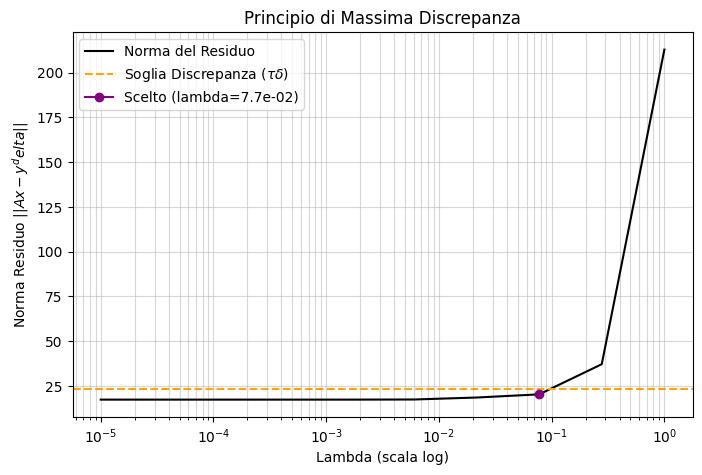

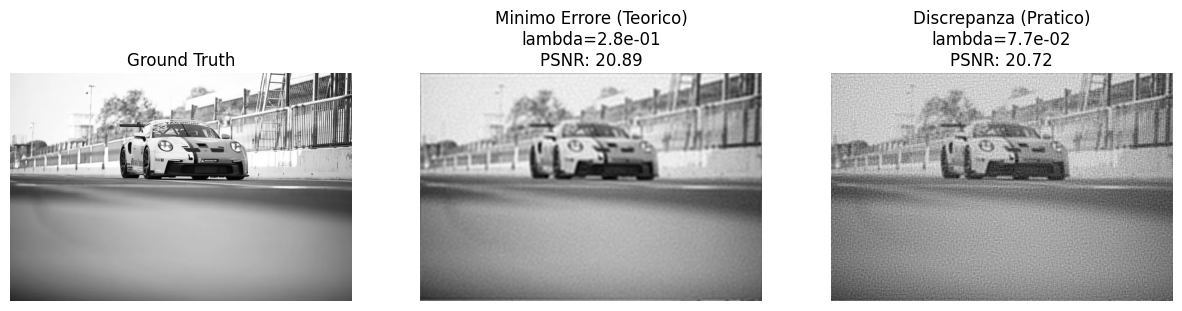

In [29]:
# Calcoliamo la norma del rumore (Delta)
# Assumiamo che 'y' sia l'immagine sfocata pulita e 'y_delta' quella rumorosa
# Se non hai 'y', sostituisci questa riga con il valore noto del rumore
norm_delta = np.linalg.norm(y_delta - y) 

# Parametro tau (fattore di sicurezza, di solito > 1)
tau = 1.1 
target_discrepancy = tau * norm_delta

# Cerchiamo nell'array dei residui il valore più vicino al target
diff_residui = np.abs(np.array(residui) - target_discrepancy)
idx_disc = np.argmin(diff_residui)
best_lam_disc = lambdas[idx_disc]

print(f"Rumore stimato (delta): {norm_delta:.4f}")
print(f"Target Discrepanza:     {target_discrepancy:.4f}")
print(f"Lambda (Discrepanza):   {best_lam_disc:.2e} con Residuo: {residui[idx_disc]:.4f}")

# --- 2. GRAFICO DEL PRINCIPIO DI DISCREPANZA ---
plt.figure(figsize=(8, 5))
plt.semilogx(lambdas, residui, 'k-', label='Norma del Residuo')
plt.axhline(y=target_discrepancy, color='orange', linestyle='--', label=f'Soglia Discrepanza ($\\tau \\delta$)')
plt.semilogx(best_lam_disc, residui[idx_disc], color='purple', marker='o', label=f'Scelto (lambda={best_lam_disc:.1e})')

plt.xlabel('Lambda (scala log)')
plt.ylabel('Norma Residuo $||Ax - y^delta||$')
plt.title('Principio di Massima Discrepanza')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.legend()
plt.show()

# --- 3. CONFRONTO VISIVO FINALE (Ground Truth vs Discrepanza) ---
plt.figure(figsize=(15, 6))

# A) Immagine Originale
plt.subplot(1, 3, 1)
plt.imshow(x, cmap='gray')
plt.title('Ground Truth')
plt.axis('off')

# B) Soluzione Migliore Teorica (Minimo Errore)
# Usiamo idx_min_err calcolato nella cella precedente
plt.subplot(1, 3, 2)
plt.imshow(x_tik_list[idx_min_err], cmap='gray')
plt.title(f'Minimo Errore (Teorico)\nlambda={best_lam_err:.1e}\nPSNR: {psnr_vector[idx_min_err]:.2f}')
plt.axis('off')

# C) Soluzione Migliore Pratica (Discrepanza)
plt.subplot(1, 3, 3)
plt.imshow(x_tik_list[idx_disc], cmap='gray')
plt.title(f'Discrepanza (Pratico)\nlambda={best_lam_disc:.1e}\nPSNR: {psnr_vector[idx_disc]:.2f}')
plt.axis('off')

plt.show()